In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_pickle("../data/reviews_vector.pkl")

In [3]:
df.columns[4:]

Index(['10', '100', '6s', 'abl', 'absolut', 'access', 'actual', 'ad', 'adapt',
       'add',
       ...
       'wont', 'work', 'worri', 'worth', 'would', 'wouldnt', 'wrong', 'year',
       'yet', 'your'],
      dtype='object', length=500)

In [4]:
df.isna()

,overall,reviewText,length,binary,10,100,6s,abl,absolut,access,...,wont,work,worri,worth,would,wouldnt,wrong,year,yet,your
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890439,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
890440,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
890441,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
890442,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [5]:
X=df[df.columns[4:]]
y=df["binary"]

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# testing for C value
penalties = [0.1, 1, 10, 100]

cvs1=[]

for c in penalties:
    # change depth each time
    estimators = [('normalise', StandardScaler()),
                ('model', LogisticRegression(C=c,penalty='l1', solver='liblinear',random_state=42))]
    pipe = Pipeline(estimators,verbose=True)
    # fitting
    pipe.fit(X_train, y_train)
    cvs =cross_val_score(pipe, X_train, y_train, cv=5).mean()
    cvs1.append(cvs)
    print(f"penalty: {c} Cross Validation accuracy: {cvs}")

[Pipeline] ......... (step 1 of 2) Processing normalise, total=   3.8s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.5min
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.9s
[Pipeline] ............. (step 2 of 2) Processing model, total=  31.6s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.8s
[Pipeline] ............. (step 2 of 2) Processing model, total=  31.8s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.8s
[Pipeline] ............. (step 2 of 2) Processing model, total=  33.4s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.9s
[Pipeline] ............. (step 2 of 2) Processing model, total=  29.0s
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   1.8s
[Pipeline] ............. (step 2 of 2) Processing model, total=  32.4s
penalty: 0.1 Cross Validation accuracy: 0.8684869201451523
[Pipeline] ......... (step 1 of 2) Processing normalise, total=   2.6s
[Pipeline] .......

In [20]:
cvs1

[0.8684869201451523, 0.8684883239396088, 0.8684911315285216, 0.868492535322978]

AttributeError: 'list' object has no attribute 'set_xticks'

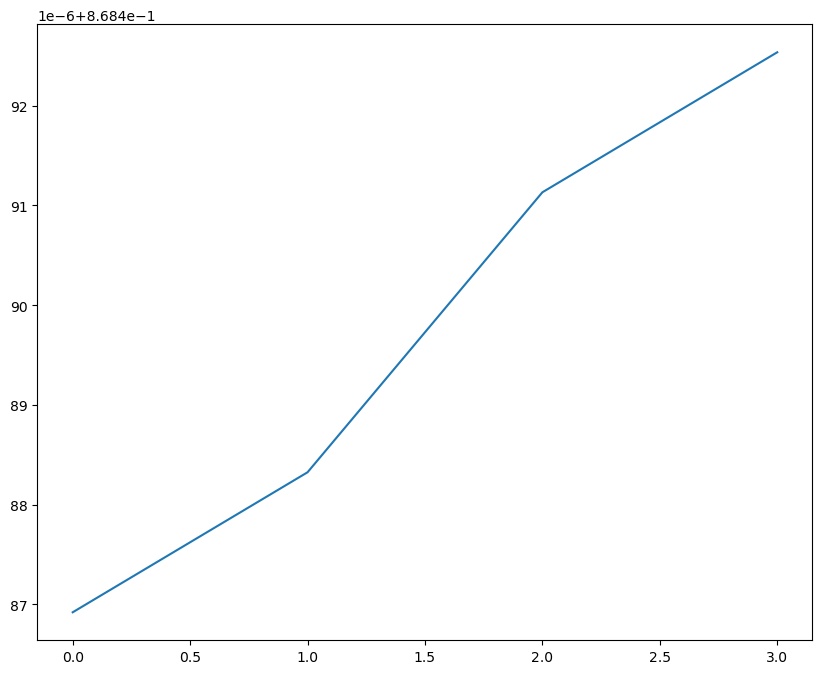

In [30]:
plt.figure(figsize=(10,8))
g = plt.plot(cvs1)
g.set_xticks(range(len(penalties)))
g.set_xticklabels(penalties)
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Penalty strength (C)")
plt.title("Test vs Train Accuracies - L1")

plt.show();

In [31]:


estimators = [('normalise', StandardScaler()), 
              ('model', LogisticRegression(C=1,penalty='l1', solver='liblinear',random_state=42))]
pipe_final = Pipeline(estimators,verbose=True)

In [32]:
pipe_final.fit(X_train, y_train)


[Pipeline] ......... (step 1 of 2) Processing normalise, total=   3.1s


In [ ]:
decision_tree_classifier = pipe[-1]
